In [3]:
import xarray as xr
from scipy.interpolate import griddata
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
# Using Antwerp Ghent and Charleroi as training set
# Brussels as testing set

In [2]:
cities = ['Antwerp','Charleroi','Ghent']
urbclim_and_feature_files = {}
era5_files = {}
for city in cities:
    urbclim_and_feature_files[city] = pd.read_csv(f'/Users/wangy/Documents/MACS/Thesis/Urbclim_and_feature/{city}_urbclim_and_features_2015_07_01to10.csv',index_col=0)
    era5_files[city] = pd.read_csv(f'/Users/wangy/Documents/MACS/Thesis/ERA5_variables/{city}/ERA5_2015_07_01to10_{city}_Corrected.csv',index_col=0)

print(urbclim_and_feature_files)
print(era5_files)

/var/folders/bv/rfp6znxd6qqbmjm5bhtmkw4m0000gn/T/ipykernel_85591/107567235.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  urbclim_and_feature_files[city] = pd.read_csv(f'/Users/wangy/Documents/MACS/Thesis/Urbclim_and_feature/{city}_urbclim_and_features_2015_07_01to10.csv',index_col=0)


{'Antwerp':                 time          y         x        tas  AHF_Antwerp.nc  \
0         2015-07-01  50.321007  4.309057  19.767511        4.658679   
1         2015-07-01  50.321075  4.310457  19.166986        4.658679   
2         2015-07-01  50.321148  4.311858  19.185938        4.658679   
3         2015-07-01  50.321217  4.313258  16.801355        4.061239   
4         2015-07-01  50.321285  4.314659  16.825250        4.061239   
...              ...        ...       ...        ...             ...   
21744235         NaN        NaN       NaN        NaN        1.723335   
21744236         NaN        NaN       NaN        NaN        1.723335   
21744237         NaN        NaN       NaN        NaN        1.723335   
21744238         NaN        NaN       NaN        NaN        1.723335   
21744239         NaN        NaN       NaN        NaN        1.723335   

          Coast_Antwerp.nc  LCZcorine_Antwerp_UrbClim_2015_01_v1.0.nc  \
0                      NaN                        

In [4]:
# Add the time feature into the df

def add_time_feature(all_variables):
    all_variables['time'] = pd.to_datetime(all_variables['time'], format='mixed')
    # Extract the hour of the day
    all_variables['hour'] = all_variables['time'].dt.hour
    # Convert time features using sin and cos
    all_variables['hour_sin'] = np.sin(2 * np.pi * all_variables['hour'] / 24)
    all_variables['hour_cos'] = np.cos(2 * np.pi * all_variables['hour'] / 24)
    
    # Extract the day of the year
    # all_variables['day_of_year'] = all_variables['time'].dt.dayofyear
    # Convert time features using sin and cos
    # df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    # df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

    # print(all_variables[['time', 'hour',  'hour_sin', 'hour_cos']])


In [ ]:
# Using brussels 2015.07.01-10 + time as comparation (this cell can be ignored)
urbclim_and_feature = pd.read_csv('/Users/wangy/Documents/MACS/Thesis/Urbclim_and_feature/Brussles_urbclim_and_features_2015_07_01to10.csv',index_col=0)
era5 = pd.read_csv('/Users/wangy/Documents/MACS/Thesis/ERA5_variables/Brussels/ERA5_Corrected/ERA5_2015_07_01to10_Brussels_Corrected.csv',index_col=0)

era5_new = era5.drop(columns=['x','y','time','t2m'])
era5_new[['t2m_corrected']] -= 273.15
# display(era5_new.columns)
urbclim_and_feature = urbclim_and_feature.drop(columns=['Unnamed: 0', 'y.1', 'x.1'])
# display(urbclim_and_feature.columns)
all_variables = pd.concat([urbclim_and_feature,era5_new], axis=1)
display(all_variables)

add_time_feature(all_variables)

all_variables.dropna(inplace=True)
all_variables.reset_index(drop=True, inplace=True)

y_train = pd.DataFrame()
# Compute the new 'tas' column
y_train['residue'] = all_variables['tas'] - all_variables['t2m_corrected']

X_train = all_variables.drop(columns=['x','y','time','tas','hour'])


In [5]:
# Add the same time features to different city df
for df in urbclim_and_feature_files.values():
    add_time_feature(df)
    

In [6]:
# This function is to combine the preprocessed urbclim data, features data and era5 data
def combine_all_features(urbclim_and_feature, era5):
    era5_new = era5.drop(columns=['x','y','time','t2m'])
    # display(era5_new.columns)
    # urbclim_and_feature = urbclim_and_feature.drop(columns=['Unnamed: 0', 'y.1', 'x.1'])
    # display(urbclim_and_feature.columns)
    all_variables = pd.concat([urbclim_and_feature,era5_new], axis=1)
    display(all_variables)
    return all_variables
    

In [7]:
# combine urbclim_feature and era5 for each city
for city in urbclim_and_feature_files.keys():
    if city in era5_files:  
        df1 = urbclim_and_feature_files[city]
        df2 = era5_files[city]
        combined_df = combine_all_features(df1, df2)  
        # update the file in urbclim_and_feature_files dict
        urbclim_and_feature_files[city] = combined_df  
    else:
        print(f"Warning: {city} not found in era5_files")


,time,y,x,tas,AHF_Antwerp.nc,Coast_Antwerp.nc,LCZcorine_Antwerp_UrbClim_2015_01_v1.0.nc,elevation_Antwerp_UrbClim_2015_01_v1.0.nc,height_Antwerp.nc,imperv_Antwerp_UrbClim_2015_01_v1.0.nc,...,cape,kx,ssr,str,sp,sshf,tcc,tcw,tp,t2m_corrected
0,2015-07-01,50.321007,4.309057,19.767511,4.658679,NaN,23.0,1273.298927,0.0,0.0,...,0.0,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.215859
1,2015-07-01,50.321075,4.310457,19.166986,4.658679,NaN,23.0,1321.636086,0.0,0.0,...,0.0,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.215569
2,2015-07-01,50.321148,4.311858,19.185938,4.658679,NaN,23.0,511.150639,0.0,0.0,...,0.0,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.220432
3,2015-07-01,50.321217,4.313258,16.801355,4.061239,NaN,23.0,618.075115,0.0,0.0,...,0.0,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.219790
4,2015-07-01,50.321285,4.314659,16.825250,4.061239,NaN,23.0,1422.742444,0.0,0.0,...,0.0,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.214962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21744235,NaT,NaN,NaN,NaN,1.723335,23985.864120,NaN,NaN,NaN,NaN,...,0.0,19.171062,2.328306e-10,-255722.991745,101553.910038,170449.098607,0.953367,23.654075,-1.734723e-18,NaN
21744236,NaT,NaN,NaN,NaN,1.723335,24129.855469,NaN,NaN,NaN,NaN,...,0.0,19.171062,2.328306e-10,-255722.991745,101553.910038,170449.098607,0.953367,23.654075,-1.734723e-18,NaN
21744237,NaT,NaN,NaN,NaN,1.723335,24129.855469,NaN,NaN,NaN,NaN,...,0.0,19.171062,2.328306e-10,-255722.991745,101553.910038,170449.098607,0.953367,23.654075,-1.734723e-18,NaN
21744238,NaT,NaN,NaN,NaN,1.723335,24129.855469,NaN,NaN,NaN,NaN,...,0.0,19.171062,2.328306e-10,-255722.991745,101553.910038,170449.098607,0.953367,23.654075,-1.734723e-18,NaN


,time,y,x,tas,AHF_Charleroi.nc,Coast_Charleroi.nc,LCZcorine_Charleroi_UrbClim_2015_01_v1.0.nc,elevation_Charleroi_UrbClim_2015_01_v1.0.nc,height_Charleroi.nc,imperv_Charleroi_UrbClim_2015_01_v1.0.nc,...,cape,kx,ssr,str,sp,sshf,tcc,tcw,tp,t2m_corrected
0,2015-07-01 00:00:00,50.321007,4.309057,19.767511,1.689140,NaN,2.0,147737.014659,0.465045,21.407955,...,0.0,5.174933,2.328306e-10,-256604.286665,100018.373897,172621.077152,0.000000,19.560486,-1.734723e-18,18.911223
1,2015-07-01 00:00:00,50.321075,4.310457,19.166986,1.689140,NaN,2.0,145967.478708,0.253712,7.730673,...,0.0,5.174933,2.328306e-10,-256604.286665,100018.373897,172621.077152,0.000000,19.560486,-1.734723e-18,18.921840
2,2015-07-01 00:00:00,50.321148,4.311858,19.185938,1.689140,NaN,18.0,148024.153233,0.007804,0.000000,...,0.0,5.174933,2.328306e-10,-256604.286665,100018.373897,172621.077152,0.000000,19.560486,-1.734723e-18,18.909500
3,2015-07-01 00:00:00,50.321217,4.313258,16.801355,1.689140,NaN,18.0,148395.251593,0.000000,0.000000,...,0.0,5.174933,2.328306e-10,-256604.286665,100018.373897,172621.077152,0.000000,19.560486,-1.734723e-18,18.907274
4,2015-07-01 00:00:00,50.321285,4.314659,16.825250,1.689140,NaN,18.0,148698.251097,0.000000,0.000000,...,0.0,5.174933,2.328306e-10,-256604.286665,100018.373897,172621.077152,0.000000,19.560486,-1.734723e-18,18.905456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9696235,2015-07-10 23:00:00,50.513588,4.563002,14.409479,2.720522,NaN,NaN,NaN,NaN,NaN,...,0.0,10.983911,2.328306e-10,-253412.040621,99900.794101,153032.289518,0.885829,18.886413,-1.734723e-18,NaN
9696236,2015-07-10 23:00:00,50.513653,4.564408,14.469568,2.720522,NaN,NaN,NaN,NaN,NaN,...,0.0,10.983911,2.328306e-10,-253412.040621,99900.794101,153032.289518,0.885829,18.886413,-1.734723e-18,NaN
9696237,2015-07-10 23:00:00,50.513720,4.565815,16.376978,2.720522,NaN,NaN,NaN,NaN,NaN,...,0.0,10.983911,2.328306e-10,-253412.040621,99900.794101,153032.289518,0.885829,18.886413,-1.734723e-18,NaN
9696238,2015-07-10 23:00:00,50.513786,4.567221,17.275903,2.720522,NaN,NaN,NaN,NaN,NaN,...,0.0,10.983911,2.328306e-10,-253412.040621,99900.794101,153032.289518,0.885829,18.886413,-1.734723e-18,NaN


,time,y,x,tas,population_Ghent.nc,LCZcorine_Ghent_UrbClim_2015_01_v1.0.nc,LCZ_Ghent_UrbClim_2015_01_v1.0.nc,Coast_Ghent.nc,elevation_Ghent_UrbClim_2015_01_v1.0.nc,imperv_Ghent_UrbClim_2015_01_v1.0.nc,...,cape,kx,ssr,str,sp,sshf,tcc,tcw,tp,t2m_corrected
0,2015-07-01 00:00:00,50.956380,3.559364,20.159906,3.479522,21.0,14.0,NaN,12946.355164,0.000000,...,0.0,15.448884,2.328306e-10,-258484.382494,101477.389853,182661.355332,0.0,21.575684,-1.734723e-18,19.988522
1,2015-07-01 00:00:00,50.956455,3.560782,20.364038,0.027388,21.0,14.0,NaN,12679.174408,1.053982,...,0.0,15.448884,2.328306e-10,-258484.382494,101477.389853,182661.355332,0.0,21.575684,-1.734723e-18,19.990125
2,2015-07-01 00:00:00,50.956535,3.562201,20.339746,0.000000,21.0,14.0,NaN,14924.397436,26.266093,...,0.0,15.448884,2.328306e-10,-258484.382494,101477.389853,182661.355332,0.0,21.575684,-1.734723e-18,19.976654
3,2015-07-01 00:00:00,50.956615,3.563619,20.933466,0.066312,3.0,14.0,NaN,11269.822635,17.922689,...,0.0,15.448884,2.328306e-10,-258484.382494,101477.389853,182661.355332,0.0,21.575684,-1.734723e-18,19.998582
4,2015-07-01 00:00:00,50.956696,3.565038,20.894647,0.630084,3.0,17.0,NaN,8275.092036,3.570645,...,0.0,15.448884,2.328306e-10,-258484.382494,101477.389853,182661.355332,0.0,21.575684,-1.734723e-18,20.016550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15120235,2015-07-10 23:00:00,51.199123,3.878829,14.714990,NaN,NaN,14.0,NaN,NaN,NaN,...,0.0,14.558352,2.328306e-10,-217357.286222,101386.872074,138730.015702,1.0,22.138414,-1.734723e-18,NaN
15120236,2015-07-10 23:00:00,51.199196,3.880256,14.702997,NaN,NaN,14.0,NaN,NaN,NaN,...,0.0,14.558352,2.328306e-10,-217357.286222,101386.872074,138730.015702,1.0,22.138414,-1.734723e-18,NaN
15120237,2015-07-10 23:00:00,51.199272,3.881682,14.713770,NaN,NaN,14.0,NaN,NaN,NaN,...,0.0,14.558352,2.328306e-10,-217357.286222,101386.872074,138730.015702,1.0,22.138414,-1.734723e-18,NaN
15120238,2015-07-10 23:00:00,51.199350,3.883109,14.694849,NaN,NaN,14.0,NaN,NaN,NaN,...,0.0,14.558352,2.328306e-10,-217357.286222,101386.872074,138730.015702,1.0,22.138414,-1.734723e-18,NaN


In [8]:
# For Antwerp, there are some data with NaN time and NaN y and x, so we need to delete them
urbclim_and_feature_files['Antwerp'] = urbclim_and_feature_files['Antwerp'].dropna(subset=['time', 'tas', 'x', 'y'])
display(urbclim_and_feature_files['Antwerp'])


,time,y,x,tas,AHF_Antwerp.nc,Coast_Antwerp.nc,LCZcorine_Antwerp_UrbClim_2015_01_v1.0.nc,elevation_Antwerp_UrbClim_2015_01_v1.0.nc,height_Antwerp.nc,imperv_Antwerp_UrbClim_2015_01_v1.0.nc,...,cape,kx,ssr,str,sp,sshf,tcc,tcw,tp,t2m_corrected
0,2015-07-01 00:00:00,50.321007,4.309057,19.767511,4.658679,NaN,23.0,1273.298927,0.000000,0.000000,...,0.000000,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.215859
1,2015-07-01 00:00:00,50.321075,4.310457,19.166986,4.658679,NaN,23.0,1321.636086,0.000000,0.000000,...,0.000000,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.215569
2,2015-07-01 00:00:00,50.321148,4.311858,19.185938,4.658679,NaN,23.0,511.150639,0.000000,0.000000,...,0.000000,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.220432
3,2015-07-01 00:00:00,50.321217,4.313258,16.801355,4.061239,NaN,23.0,618.075115,0.000000,0.000000,...,0.000000,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.219790
4,2015-07-01 00:00:00,50.321285,4.314659,16.825250,4.061239,NaN,23.0,1422.742444,0.000000,0.000000,...,0.000000,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.214962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9696235,2015-07-10 23:00:00,50.513588,4.563002,14.409479,9.886247,27285.527344,12.0,15984.017013,1.063363,20.028513,...,970.703193,33.760195,2.091461e+06,-261735.381533,101419.533128,-519994.194391,0.913082,38.480674,3.224332e-04,24.930259
9696236,2015-07-10 23:00:00,50.513653,4.564408,14.469568,9.886247,27285.527344,12.0,17428.538787,0.000000,0.687446,...,970.703193,33.760195,2.091461e+06,-261735.381533,101419.533128,-519994.194391,0.913082,38.480674,3.224332e-04,24.921592
9696237,2015-07-10 23:00:00,50.513720,4.565815,16.376978,9.886247,27354.138004,12.0,18644.778328,0.000000,0.559894,...,970.703193,33.760195,2.091461e+06,-261735.381533,101419.533128,-519994.194391,0.913082,38.480674,3.224332e-04,24.914294
9696238,2015-07-10 23:00:00,50.513786,4.567221,17.275903,9.886247,27408.939453,12.0,19549.156131,0.000000,1.131432,...,970.703193,33.760195,2.091461e+06,-261735.381533,101419.533128,-519994.194391,0.913082,38.480674,3.224332e-04,24.908868


In [ ]:
# Sample the data
def sample_data(df):
    # Sample each group and extract one-third of the rows
    grouped = df.groupby('time', group_keys=False)
    sampled = grouped.apply(lambda group: group.sample(frac = 1/3, random_state=42))
    
    # Reset indexes to avoid multiple indexes when grouping
    sampled = sampled.reset_index(drop=True)
    display(sampled)
    return sampled


In [ ]:
for city in urbclim_and_feature_files.keys():
    df = urbclim_and_feature_files[city]
    df_new = sample_data(df)
    # Update the urbclim_and_feature_files dict
    urbclim_and_feature_files[city] = df_new


In [11]:
def standardize_columns(columns):
    return [col.replace('_Brussels', '').replace('_Antwerp', '').replace('_Ghent', '').replace('_Charleroi', '') for col in columns]

for city in urbclim_and_feature_files.keys():
    df = urbclim_and_feature_files[city]
    df.columns = standardize_columns(df.columns)
  
# Select the column order of Antwerp df as the basis
base_columns = urbclim_and_feature_files['Antwerp'].columns

# Adjust the column order of df2 and df3 to be consistent with df1
urbclim_and_feature_files['Ghent'] = urbclim_and_feature_files['Ghent'][base_columns]
urbclim_and_feature_files['Charleroi'] = urbclim_and_feature_files['Charleroi'][base_columns]


print("df1 columns:", urbclim_and_feature_files['Ghent'].columns)
print("df2 columns:", urbclim_and_feature_files['Charleroi'].columns)


df1 columns: Index(['time', 'y', 'x', 'tas', 'AHF.nc', 'Coast.nc',
       'LCZcorine_UrbClim_2015_01_v1.0.nc',
       'elevation_UrbClim_2015_01_v1.0.nc', 'height.nc',
       'imperv_UrbClim_2015_01_v1.0.nc', 'LCZ_UrbClim_2015_01_v1.0.nc',
       'population.nc', 'surface.nc', 'volume.nc', 'hour', 'hour_sin',
       'hour_cos', 'u10', 'v10', 'blh', 'cape', 'kx', 'ssr', 'str', 'sp',
       'sshf', 'tcc', 'tcw', 'tp', 't2m_corrected'],
      dtype='object')
df2 columns: Index(['time', 'y', 'x', 'tas', 'AHF.nc', 'Coast.nc',
       'LCZcorine_UrbClim_2015_01_v1.0.nc',
       'elevation_UrbClim_2015_01_v1.0.nc', 'height.nc',
       'imperv_UrbClim_2015_01_v1.0.nc', 'LCZ_UrbClim_2015_01_v1.0.nc',
       'population.nc', 'surface.nc', 'volume.nc', 'hour', 'hour_sin',
       'hour_cos', 'u10', 'v10', 'blh', 'cape', 'kx', 'ssr', 'str', 'sp',
       'sshf', 'tcc', 'tcw', 'tp', 't2m_corrected'],
      dtype='object')


In [ ]:
# combine 3 city files together to obtain the final training set
training_set = pd.concat([
    # urbclim_and_feature_files['Antwerp'],
    urbclim_and_feature_files['Charleroi'],
    urbclim_and_feature_files['Ghent']
], ignore_index=True)
print(training_set)

In [ ]:
# delete all the NaN value here
training_set.dropna(inplace=True)
training_set.reset_index(drop=True, inplace=True)

y_train = pd.DataFrame()
# Calculate the residue
y_train['residue'] = training_set['tas'] - training_set['t2m_corrected']

X_train = training_set.drop(columns=['x','y','time','tas','hour'])


In [ ]:
display(y_train)
display(X_train.columns)

In [12]:
urbclim_and_feature = pd.read_csv('/Users/wangy/Documents/MACS/Thesis/UrbClim_data/Brussels/Brussles_urbclim_and_features_2016_07_01to03.csv')
era5 = pd.read_csv('/Users/wangy/Documents/MACS/Thesis/ERA5_variables/Brussels/ERA5_Corrected/ERA5_2016_07_01to03_Brussels_Corrected.csv')

urbclim_and_feature = urbclim_and_feature.drop(columns=[ 'Unnamed: 0','Unnamed: 0.1','y.1','x.1'])
era5_new = era5.drop(columns=['x','y','time'])
era5_new = era5_new.drop(columns=[ 'Unnamed: 0','Unnamed: 0.1','t2m'])
all_variables = pd.concat([urbclim_and_feature,era5_new], axis=1)
add_time_feature(all_variables)

# delete all the NaN value here
all_variables.dropna(inplace=True)
all_variables.reset_index(drop=True, inplace=True)


# Adjust the column order of test set
all_variables.columns = standardize_columns(all_variables.columns)
base_columns = urbclim_and_feature_files['Antwerp'].columns
all_variables = all_variables[base_columns]

y_test = pd.DataFrame()
# Calculate the residue
y_test['residue'] = all_variables['tas'] - all_variables['t2m_corrected']
X_test = all_variables.drop(columns=['x','y','time','tas','hour'])

print(X_test.columns)

Index(['AHF.nc', 'Coast.nc', 'LCZcorine_UrbClim_2015_01_v1.0.nc',
       'elevation_UrbClim_2015_01_v1.0.nc', 'height.nc',
       'imperv_UrbClim_2015_01_v1.0.nc', 'LCZ_UrbClim_2015_01_v1.0.nc',
       'population.nc', 'surface.nc', 'volume.nc', 'hour_sin', 'hour_cos',
       'u10', 'v10', 'blh', 'cape', 'kx', 'ssr', 'str', 'sp', 'sshf', 'tcc',
       'tcw', 'tp', 't2m_corrected'],
      dtype='object')


In [ ]:
print(y_train)
print(X_train)
print(y_test)
print(X_test)

In [9]:
# draw the trend of tas and t2m
import pandas as pd
import matplotlib.pyplot as plt
def plot_tem_over_time(df,city):
    plt.figure(figsize=(12, 6))
    plt.plot(df['time'], df['tas'], label='TAS (Temperature)', color='blue', linestyle='-', linewidth=1)
    plt.plot(df['time'], df['t2m_corrected'], label='T2M Corrected', color='orange', linestyle='--', linewidth=1)
    plt.legend()
    plt.title(f'Temperature Trends Over Time {city}', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

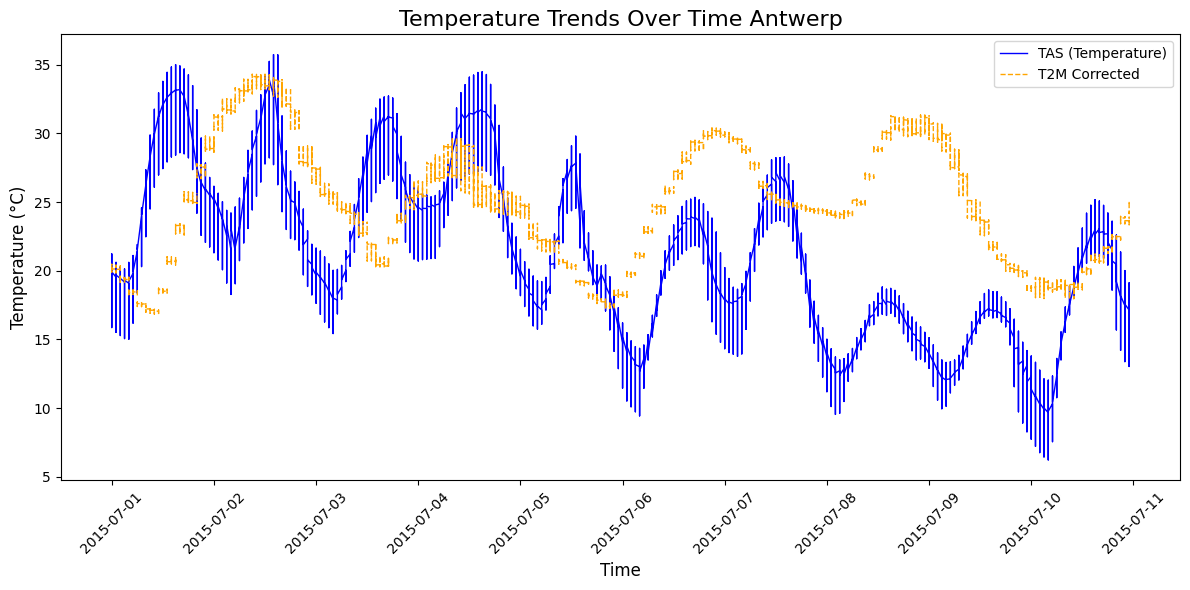

/var/folders/bv/rfp6znxd6qqbmjm5bhtmkw4m0000gn/T/ipykernel_85591/1797906754.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/wangy/Documents/MACS/Thesis/thesis_code/thesis_featurevisual/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


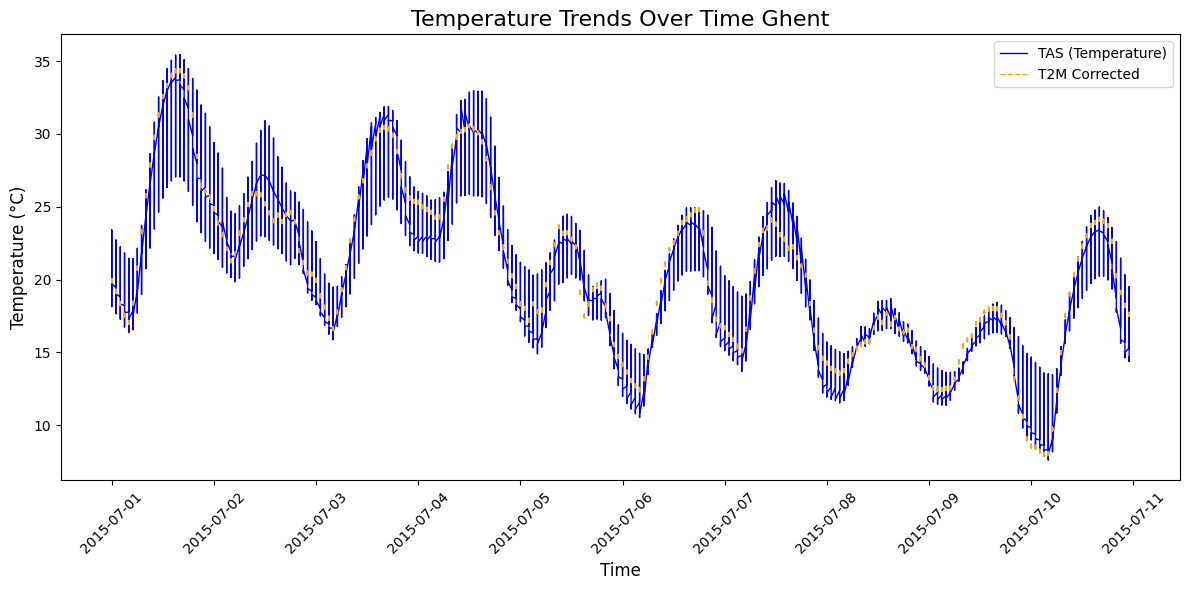

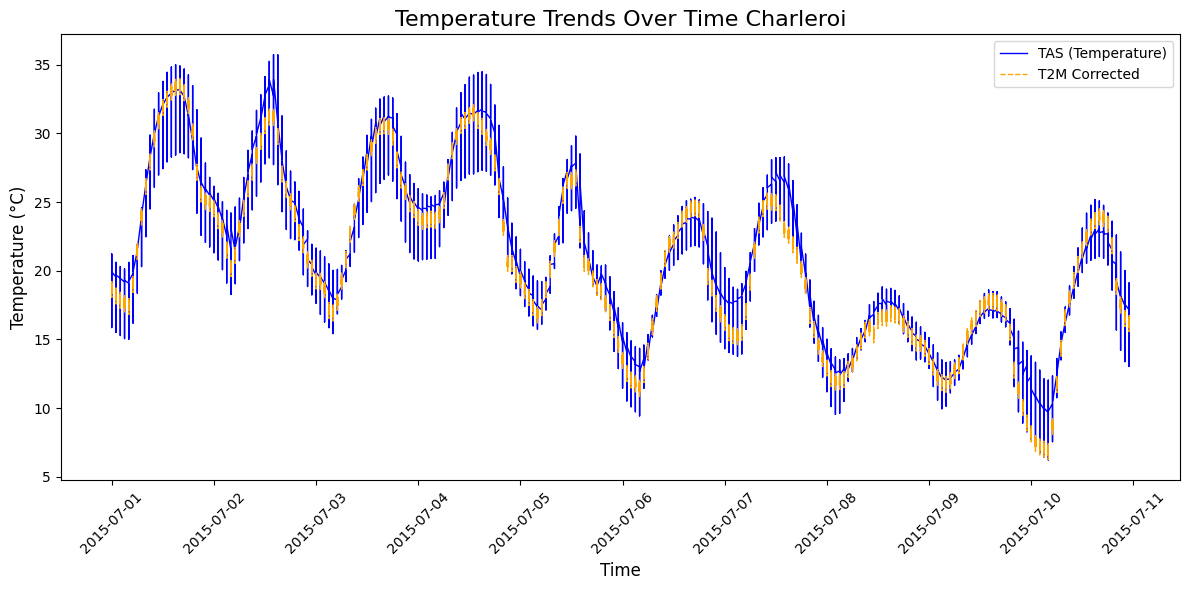

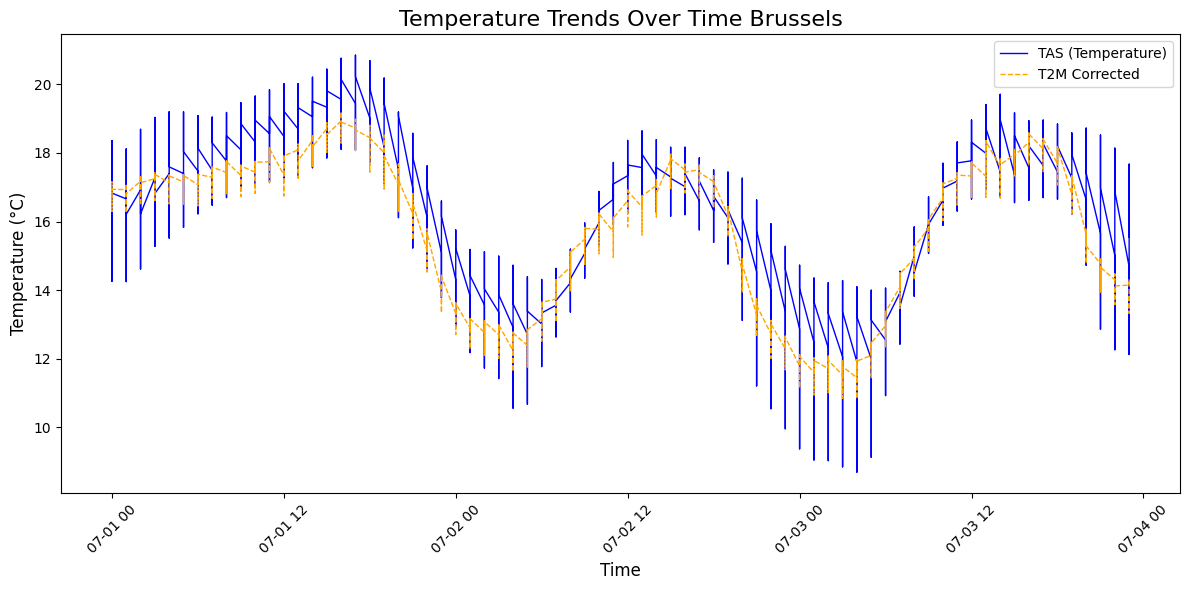

In [13]:
plot_tem_over_time(urbclim_and_feature_files['Antwerp'],'Antwerp')
plot_tem_over_time(urbclim_and_feature_files['Ghent'],'Ghent')
plot_tem_over_time(urbclim_and_feature_files['Charleroi'],'Charleroi')
plot_tem_over_time(all_variables,'Brussels')

In [ ]:
def plot_y(df, model_name):
  plt.figure(figsize=(10, 8))
  plt.scatter(df['x'], df['y'], c=df['tas'], cmap='viridis', s=1, vmin = 15, vmax = 21)  # 使用 'viridis' 色彩映射
  plt.colorbar(label='Temperature (tas)')
  plt.xlabel('Longitude (x)')
  plt.ylabel('Latitude (y)')
  plt.title(f'Geographical Distribution of Temperature - {model_name}')
  plt.show()

In [ ]:
urbclim_true_value = all_variables[['y','x','time','tas']]
print(urbclim_true_value)

In [ ]:
# first_timestamp_true = urbclim_true_value[(urbclim_true_value['time']=="2016-07-01 00:00:00") | (urbclim_true_value['time']=="2016-07-01")]
first_timestamp_true = urbclim_true_value[(urbclim_true_value['time']=="2016-07-01 12:00:00")]
print(first_timestamp_true)
tas_min = first_timestamp_true['tas'].min()
tas_max = first_timestamp_true['tas'].max()
print("tas min: " ,tas_min)
print("tas max: " ,tas_max)
plot_y(first_timestamp_true, 'True data')


In [ ]:
linear_model = LinearRegression()
# X_train = X_train.drop(columns = ['Unnamed: 0'])
linear_model.fit(X_train, y_train)
# X_test = X_test.drop(columns = ['hour'])

# Predict y
y_pred_lr = linear_model.predict(X_test)
y_pred_lr = pd.DataFrame(y_pred_lr, columns=['residue'])
print(y_pred_lr)

In [ ]:
y_pred_lr[['y','x','time']] = all_variables[['y','x','time']]
y_test[['y','x','time']] = all_variables[['y','x','time']]

y_pred_lr_day = y_pred_lr[(y_pred_lr['time'].dt.hour >= 6) & (y_pred_lr['time'].dt.hour < 18)]
y_pred_lr_night = y_pred_lr[(y_pred_lr['time'].dt.hour < 6) | (y_pred_lr['time'].dt.hour >= 18)]
y_test_day = y_test[(y_test['time'].dt.hour >= 6) & (y_test['time'].dt.hour < 18)]
y_test_night = y_test[(y_test['time'].dt.hour < 6) | (y_test['time'].dt.hour >= 18)]

print(y_pred_lr_day)
print(y_pred_lr_night)
print(y_test_day)
print(y_test_night)




In [ ]:
# compute the errors
# compute MAE (Mean Absolute Error)
def calculate_errors(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae}")
    
    # compute MSE (Mean Squared Error)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE): {mse}")
    
    # compute RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    
    # compute R² (R-squared)
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared (R²): {r2}")



In [ ]:
calculate_errors(y_test['residue'], y_pred_lr['residue'])

In [ ]:
print("Errors during day:")
calculate_errors(y_test_day['residue'], y_pred_lr_day['residue'])
print("Errors during night:")
calculate_errors(y_test_night['residue'], y_pred_lr_night['residue'])

In [ ]:
# sum up y_pred and corrected ERA5 to get the urbclim prediction
urbclim_pred_lr = pd.DataFrame()

urbclim_pred_lr['tas'] = y_pred_lr['residue'] + all_variables['t2m_corrected']
urbclim_pred_lr[['y','x','time']] = all_variables[['y','x','time']]

print(urbclim_pred_lr)

In [ ]:
# extract the first timestamp y_pred and plot it
# first_stamp_data = urbclim_pred[(urbclim_pred['time']=="2015-07-01 00:00:00") | (urbclim_pred['time']=="2015-07-01")]
first_stamp_data_lr = urbclim_pred_lr[(urbclim_pred_lr['time']=="2016-07-01 12:00:00")]
print(first_stamp_data_lr)
tas_min_lr = first_stamp_data_lr['tas'].min()
tas_max_lr = first_stamp_data_lr['tas'].max()
print("tas min: " ,tas_min_lr)
print("tas max: " ,tas_max_lr)
plot_y(first_stamp_data_lr, 'Linear regression')

In [ ]:
#use ANN model to predict the temp
from sklearn.neural_network import MLPRegressor


ann_model = MLPRegressor(hidden_layer_sizes=(4, 2),
                                activation='relu',
                                solver='adam',
                                max_iter=100,
                                random_state=45,
                                early_stopping=True,
                                validation_fraction=0.1,
                                n_iter_no_change=20,
                                alpha=0.03)

# y_train = y_train.ravel()
ann_model.fit(X_train, y_train)

y_pred_mlp = ann_model.predict(X_test)
y_pred_mlp = pd.DataFrame(y_pred_mlp, columns=['residue'])
print(y_pred_mlp)

In [ ]:
y_pred_mlp[['y','x','time']] = all_variables[['y','x','time']]


y_pred_mlp_day = y_pred_mlp[(y_pred_mlp['time'].dt.hour >= 6) & (y_pred_mlp['time'].dt.hour < 18)]
y_pred_mlp_night = y_pred_mlp[(y_pred_mlp['time'].dt.hour < 6) | (y_pred_mlp['time'].dt.hour >= 18)]

print(y_pred_mlp_day)
print(y_pred_mlp_night)


In [ ]:
calculate_errors(y_test['residue'], y_pred_mlp['residue'])

In [ ]:
print("Errors during day:")
calculate_errors(y_test_day['residue'], y_pred_mlp_day['residue'])
print("Errors during night:")
calculate_errors(y_test_night['residue'], y_pred_mlp_night['residue'])

In [ ]:
# sum up y_pred and corrected ERA5 to get the urbclim prediction
urbclim_pred_mlp = pd.DataFrame()

urbclim_pred_mlp['tas'] = y_pred_mlp['residue'] + all_variables['t2m_corrected']
urbclim_pred_mlp[['y','x','time']] = all_variables[['y','x','time']]

print(urbclim_pred_mlp)



In [ ]:
# extract the first timestamp y_pred and plot it
# first_stamp_data = urbclim_pred[(urbclim_pred['time']=="2016-07-01 12:00:00") | (urbclim_pred['time']=="2016-07-01")]
first_stamp_data_mlp = urbclim_pred_mlp[(urbclim_pred_mlp['time']=="2016-07-01 12:00:00")]
tas_min_mlp = first_stamp_data_mlp['tas'].min()
tas_max_mlp = first_stamp_data_mlp['tas'].max()
print("tas min: " ,tas_min_mlp)
print("tas max: " ,tas_max_mlp)
plot_y(first_stamp_data_mlp, 'MLP')

In [ ]:
# calculate the error matric for corrected era5 with urbclim for test set
urbclim_true = all_variables['tas']
era5_true = all_variables['t2m_corrected']
calculate_errors(urbclim_true, era5_true)

In [ ]:
urbclim_true_day = all_variables[(all_variables['time'].dt.hour >= 6) & (all_variables['time'].dt.hour < 18)][['tas']]
urbclim_true_night =  all_variables[(all_variables['time'].dt.hour < 6) | (all_variables['time'].dt.hour >= 18)][['tas']]
era5_true_day = all_variables[(all_variables['time'].dt.hour >= 6) & (all_variables['time'].dt.hour < 18)][['t2m_corrected']]
era5_true_night = all_variables[(all_variables['time'].dt.hour < 6) | (all_variables['time'].dt.hour >= 18)][['t2m_corrected']]
print("Errors during day:")
calculate_errors(urbclim_true_day['tas'], era5_true_day['t2m_corrected'])
print("Errors during night:")
calculate_errors(urbclim_true_night['tas'], era5_true_night['t2m_corrected'])


In [ ]:
ERA5_plot = all_variables[(all_variables['time'] == "2016-07-01 12:00:00")][['t2m_corrected','x','y']]
ERA5_plot = ERA5_plot.rename(columns={'t2m_corrected': 'tas'})
tas_min = ERA5_plot['tas'].min()
tas_max = ERA5_plot['tas'].max()
print("tas min: " ,tas_min)
print("tas max: " ,tas_max)
plot_y(ERA5_plot, 'ERA5')

